In [13]:
from signal_generator import generate_zigzag_signal, generate_circle_signal, plot_acceleration, plot_trajectory
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

In [14]:
def plot_spectrum(time, signal, fs):
    N = len(time)
    spectrum = np.fft.fft(signal)  # discrete Fourier-transform
    spectrum_db = 20 * np.log10(np.abs(spectrum) + 1e-12)  # 1e-12 prevents log(0)
    frequencies = np.fft.fftfreq(N, 1 / fs)  # frequency vector
    plt.plot(frequencies, spectrum_db)
    plt.title('Frequenzspektrum')
    plt.xlabel('Frequenz [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.grid(True)
    plt.show()

In [15]:
def calculate_trajectory(acceleration):
    # Rechteckregel
    # H(z)=1/(1-z^-1)
    b = [1]         # Zählerkoeffizienten
    a = [1, -1]     # Nennerkoeffizienten

    # Rechteck-Trapez-Regel
    #b = [7/8, -1/7]  # Zählerkoeffizienten
    #a = [7/8, -7/8]  # Nennerkoeffizienten

    # remove bias from acceleration
    #acceleration[:, 1] -= np.mean(acceleration[:, 1])
    #acceleration[:, 2] -= np.mean(acceleration[:, 2])
    #acceleration[:, 3] -= np.mean(acceleration[:, 3])

    fs = 100  # Beispielhafte Abtastfrequenz
    dt = 1 / fs  # Zeitintervall

    v0 = [0, 0, 0]  # Startgeschwindigkeit [vx0, vy0, vz0]
    p0 = [0, -1, -0.5]  # Startposition [px0, py0, pz0]

    # first integration
    vx = lfilter(b, a, acceleration[:, 1]) * dt + v0[0]
    vy = lfilter(b, a, acceleration[:, 2]) * dt + v0[1]
    vz = lfilter(b, a, acceleration[:, 3]) * dt + v0[2]

    # second integration
    px = lfilter(b, a, vx) * dt
    py = lfilter(b, a, vy) * dt
    pz = lfilter(b, a, vz) * dt

    position = np.vstack([px, py, pz])
    position = np.transpose(position)
    return position

(188, 3)
(188, 3)


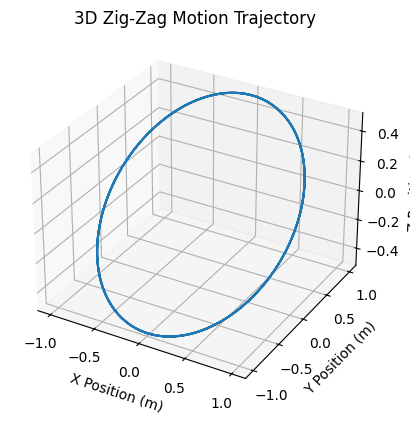

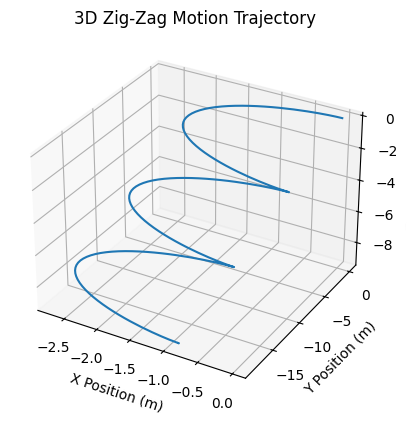

In [16]:
acceleration, position = generate_circle_signal(v=10, fs=100, p=3, snr=50)
#acceleration, position = generate_zigzag_signal(A=(0,0,0), B=(1,1,1), v=0.5, fs=100, p=2, snr=20)
t = acceleration[:, 0]
ax = acceleration[:, 1]
calculated_position = calculate_trajectory(acceleration)
print(position.shape)
print(calculated_position.shape)
plot_trajectory(position)
plot_trajectory(calculated_position)